<a href="https://colab.research.google.com/github/GarethCW/GCW/blob/master/Handwritting_Project_Guassian_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Written Numbers using Guassian Bayes

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import os
from sklearn.model_selection import train_test_split
import random
from PIL import Image
import seaborn as sns




In [0]:
data = pd.read_csv('train.csv')
data.head()
X = data.to_numpy()
X = X[:,3:-1]
y = data.to_numpy()
y = y[:,-1]

data = pd.read_csv('test.csv')
X_test = data.to_numpy()
X_test = X_test[:,3:-1]
y_test = data.to_numpy()
y_test = y_test[:,-1]


data = [] #Clears to save space

# Images of the handwritings

Reshaping the 784x1 array to a 28x28 matrix so you can display the image.

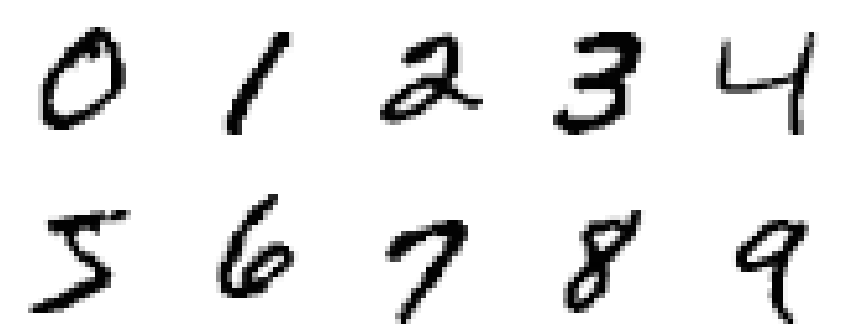

In [3]:
image = plt.figure(figsize=(15,6))
for k in range(10):
  X_i = [0]*784
  for i in range(len(y)):
    if y[i] == k:
      X_i = X[i,:]
      X_i = np.reshape(X_i,(28,28))
      plt.subplot(2, 5, k+1)
      plt.imshow(X_i, cmap='Greys',  interpolation='nearest')
      plt.axis('off')
      break
plt.show()

#Naive Bayes Class

Given a vector with a value to represent certain features, Naive Bayes will be able to make a decision on which number is which using the mean and varience from the vector given to it. 

In [0]:
class NaiveB:
  def fit(self, X, y, epsilon = 1175):
    N, D = X.shape
    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))

    for k in self.K:
      X_k = X[y==k,:]
      self.likelihoods[k] = {'mean': X_k.mean(axis =0), 'covarience' : X_k.var(axis = 0) + epsilon}
      self.priors[k] = len(X_k)/len(X)

  def predict(self, X):
    N, D = X.shape
    P_hat = np.zeros((N, len(self.K)))

    for k, l in self.likelihoods.items():
      P_hat[:,k] = mvn.logpdf(X, l['mean'],l['covarience']) + np.log(self.priors[k]) #This p_hat formula
    
    return P_hat.argmax(axis = 1)

#Guassian Naive Bayes Class

Instead of using just the mean and varience, like in the previous Naive Bayes algorthim above. The Guassian method normalizes the data and from the probability distribution of features in certain classes, Gaussian Naive Bayes acan make a decision on which number it is by picking the the number that has the highest probability. This method is know to be best at image recognition.

In [0]:
class GuassNB:
  def fit(self, X, y, epsilon = 1175):
    N, D = X.shape
    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))

    for k in self.K:
      X_k = X[y==k,:]
      mu_k = X_k.mean(axis=0)
      self.likelihoods[k] = {'mean': X_k.mean(axis=0), 'covarience': (1/(N-1))*np.matmul((X_k - mu_k).T, X_k-mu_k) + epsilon*np.identity(D)}
      self.priors[k] = len(X_k)/len(X)

  def predict(self, X):
    N, D = X.shape
    P_hat = np.zeros((N, len(self.K)))

    for k, l in self.likelihoods.items():
      P_hat[:,k] = mvn.logpdf(X, l['mean'],l['covarience']) + np.log(self.priors[k]) #This p_hat formula
    
    return P_hat.argmax(axis = 1)

  def confusion_matrix(self,X,y):
    n = 10
    matrix = np.zeros((n,n))
    for k in range(n):
      for i in range(n):
         matrix[k][i] = sum(X[y==i])
      matrix[k][:] = matrix[k][:]/sum(matrix[k][:])
    return matrix



#Bernoulli Naive Bayes Class

Bernoulli Naive Bayes requires a binary data set in order for it to function. Although it is not the best method compared to the Gaussian method, its true strength is in text reading. For example, documents with certain words appearing being labeled as "1" or "0" can help identify if a document is spam or not spam.

In [0]:
class BernNB:
  def fit(self, X, y, epsilon = 1e-10):
    N, D = X.shape
    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))

    for k in self.K:
      X_k = X[y==k,:]
      p = (sum(X_k)+1)/(len(X_k)+2) # Look this up, it is a statisics thing I forgot the name of
      self.likelihoods[k] = {'mean': p, 'cov': p * (1 - p) + epsilon}
      self.priors[k] = len(X_k)/len(X)


  def predict(self, X):
    N, D = X.shape
    P_hat = np.zeros((N, len(self.K)))

    for k, l in self.likelihoods.items():
      # Using the Bernouille function/formula. Trick is to get the matrix/vectors to go from mxn to a 1x1 number for each k value.
      P_hat[:,k] = np.log(self.priors[k]) + np.matmul(X, np.log(l['mean'])) + np.matmul((1 - X), np.log(abs(1-l['mean'])))
    
    return P_hat.argmax(axis = 1)


In [0]:
def accuracy(y, y_hat): #This is our function to find accuracy
  return np.mean(y == y_hat)

## Images of Averages for each Number

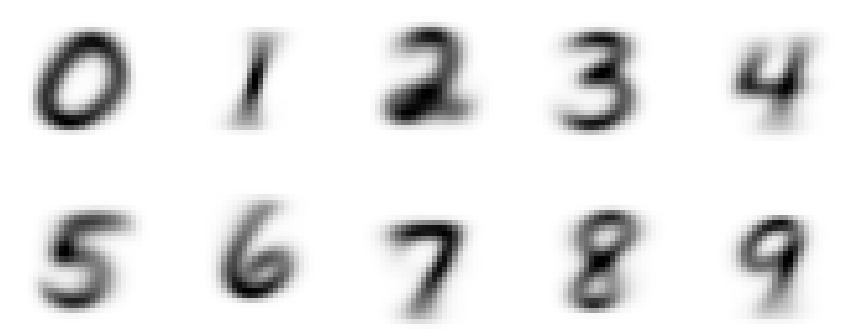

In [8]:
image = plt.figure(figsize=(15,6))
for k in range(10):
  count = 0
  X_i = [0]*784
  for i in range(len(y)):
    if y[i] == k:
      X_i += X[i,:]
      count += 1
  X_i = X_i/count
  X_i = np.reshape(X_i,(28,28))
  plt.subplot(2, 5, k+1)
  plt.imshow(X_i, cmap='Greys',  interpolation='nearest')
  plt.axis('off')

plt.show()

#Naive Bayes Accuracy (81.38%)

In [9]:
nb = NaiveB()
nb.fit(X,y) #Use the X and Y Training set here
y_hat = nb.predict(X_test) #Use the X Test set here
print(accuracy(y_test,y_hat)) #0.9606 at e = 1175

0.8138


# Guassian Naive Bayes Accuracy (96.06%)

In [10]:
gnb = GuassNB()
gnb.fit(X,y) #Use the X and Y Training set here
y_hat = gnb.predict(X_test) #Use the X Test set here
print(accuracy(y_test,y_hat)) #0.9606 at e = 1175

0.9606


Below will find all the error looking numbers and convert it to image files

In [0]:
#image = plt.figure(figsize=(15,6))
#for i in range(lens(X_test)):
#  X_i = [0]*784
#  if y_test[i] != y_hat[i]:
#    X_i = X_test[i,:]
#    X_i = np.reshape(X_i,(28,28))
#    plt.imshow(X_i, cmap='Greys',  interpolation='nearest')
#    plt.axis('off')
#    plt.show()

#Bernoulli Naive Bayes Method (84.44%)

Convert X data into a binary form. Any x value less than 127 will be 0 and anything above 127 will be 1.

In [0]:
# This will quickly change all the variables to a 0 or 1 within a certain range
X[np.where(X <= 100)] = 0
X[np.where(X > 100)] = 1
X_test[np.where(X_test <=100)] = 0
X_test[np.where(X_test > 100)] = 1


In [13]:
bnb = BernNB()
bnb.fit(X,y) #Use the X and Y Training set here
y_hat = bnb.predict(X_test) #Use the X Test set here
print(accuracy(y_test,y_hat)) #0.9606 at e = 1175

0.8444


### Conclusion

In conclusion, Guassian Naive Bayes was the most accurate algorthim to identify the numbers from handwritten files. 